In [22]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import TrainingArguments, Trainer, ViTForImageClassification, ViTImageProcessor
from dataset import CustomImageSet
from plots import plot_confusion_matrix
from sklearn.metrics import classification_report

In [6]:
cuda = torch.device("cuda")

In [7]:
train_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/train"
validation_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/val"
test_path = "C:/Users/voicu/OneDrive/Desktop/licenta/OCT2017/test"

In [8]:
category_names = {0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}

In [9]:
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

# define the transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

In [10]:
train_dataset = CustomImageSet(img_dir=train_path, number_of_img=1000, transform=data_transforms)
val_dataset = CustomImageSet(img_dir=validation_path, transform=data_transforms)
test_dataset = CustomImageSet(img_dir=test_path, transform=data_transforms)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=4).to(cuda)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,
    eval_strategy="steps",
    num_train_epochs=4,
    fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True
)

In [14]:
def data_collator(features):
    pixel_values = torch.stack([f[0] for f in features])
    labels = torch.tensor([f[1] for f in features])
    return {"pixel_values": pixel_values, "labels": labels}

In [15]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor
)

In [17]:
train_results = trainer.train()

C:\Users\voicu\PycharmProjects\license\venv\Lib\site-packages\transformers\models\vit\modeling_vit.py:253: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


Step,Training Loss,Validation Loss


In [18]:
test_results = trainer.predict(test_dataset)
print(f"Test predictions: {test_results.metrics}")

Test predictions: {'test_loss': 0.31522589921951294, 'test_accuracy': 0.9126470588235294, 'test_precision': 0.9128405493629477, 'test_recall': 0.9126470588235294, 'test_f1': 0.9117235688755001, 'test_runtime': 56.6825, 'test_samples_per_second': 59.983, 'test_steps_per_second': 7.498}


In [19]:
predicted_labels = np.argmax(test_results.predictions, axis=1)
true_labels = test_results.label_ids

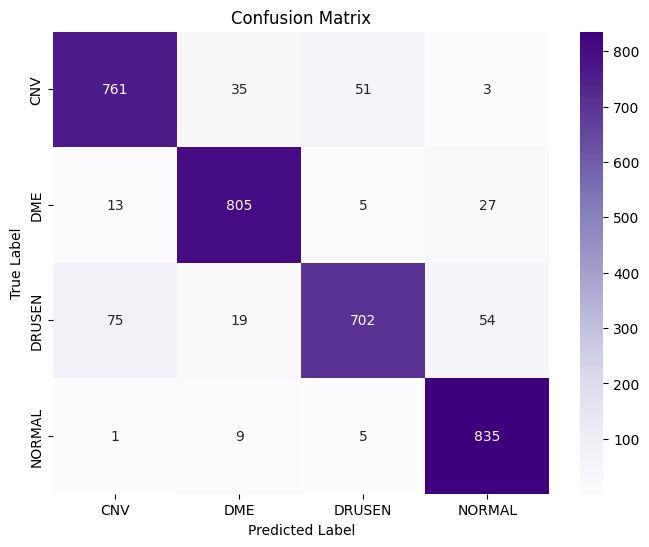

In [20]:
plot_confusion_matrix(true_labels, predicted_labels)

In [23]:
classification_rep = classification_report(true_labels, predicted_labels)
print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       850
           1       0.93      0.95      0.94       850
           2       0.92      0.83      0.87       850
           3       0.91      0.98      0.94       850

    accuracy                           0.91      3400
   macro avg       0.91      0.91      0.91      3400
weighted avg       0.91      0.91      0.91      3400

